In [2]:
import numpy as np
from math import sqrt
import random

In [3]:
# Function to calculate Euclidean distance
def euclidean_distance(p1, p2):
    return sqrt(sum((p1[i] - p2[i])**2 for i in range(len(p1))))

In [4]:
# Brute-force KNN implementation
def brute_force_knn(data, query, k):
    distances = [(euclidean_distance(query, point), point) for point in data]
    distances.sort(key=lambda x: x[0])
    return [dist[1] for dist in distances[:k]]

In [47]:
from collections import namedtuple

# Named tuple for storing node information
Node = namedtuple('Node', 'point axis left right partition')

# KD-tree construction
def create_kdtree(points, depth=0):
    if len(points) == 0:
        return None

    # Select the axis based on the depth
    axis = depth % len(points[0])

    # Sort the points based on the selected axis
    points = sorted(points, key=lambda point: point[axis])

    # Select the median as the node point
    median = len(points) // 2

    # Partition boundaries
    partition = None
    if len(points) > 1:
        if axis == 0:
            partition = [points[median][0], (points[median-1][1], points[-1][1])]
        else:
            partition = [(points[0][0], points[-1][0]), points[median][1]]

    # Create the node and recursively construct the left and right subtrees
    node = Node(point=points[median], axis=axis,
                left=create_kdtree(points[:median], depth + 1),
                right=create_kdtree(points[median + 1:], depth + 1),
                partition=partition)


    return node


In [48]:
# Function to find the k nearest neighbors using the KD-tree
def kdtree_knn(root, query, k):
    def traverse(node, path, best):
        if node is None:
            return best

        # Calculate the distance between the query and the current node
        distance = euclidean_distance(query, node.point)

        path.append((distance, node.point))
        path.sort(key=lambda x: x[0])

        if len(path) > k:
            path.pop()

        best = min(best, path[-1][0])

        # Check if the query should be looked at in the left or right subtree
        if query[node.axis] < node.point[node.axis]:
            best = traverse(node.left, path, best)
            if distance < best:
                best = traverse(node.right, path, best)
        else:
            best = traverse(node.right, path, best)
            if distance < best:
                best = traverse(node.left, path, best)

        return best

    path = []
    best = float('inf')
    traverse(root, path, best)
    return [point for _, point in path]

In [49]:
N = 100
D = 2
k = 5

In [50]:
# Generate a random dataset
data = [[random.uniform(-10, 10) for _ in range(D)] for _ in range(N)]

# query point
query = [random.uniform(-10, 10) for _ in range(D)]
query

[-0.4720512632688134, 7.1414272982354525]

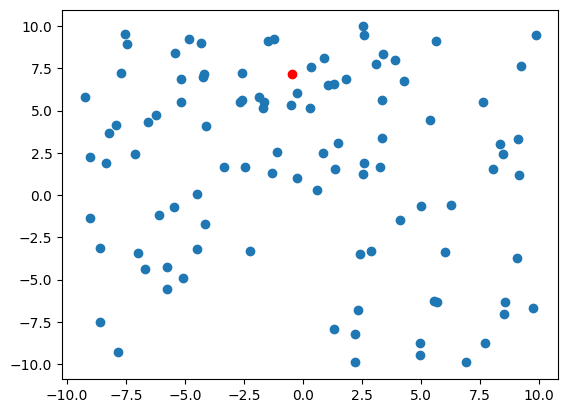

In [51]:
# Plot the 2D dataset and query point
import matplotlib.pyplot as plt

data_plot = np.array(data)
plt.scatter(data_plot[:,0], data_plot[:,1])
plt.scatter(query[0], query[1], c='red')
plt.show()

Brute-force KNN:
The 5 nearest neighbors are:
[0.3621047332580307, 7.608870329172273]
[-0.2444149177299053, 6.042510621597163]
[0.88172156387337, 8.095797640625022]
[1.0701221790246365, 6.49310877046036]
[-0.49669875045095857, 5.318839186415769]


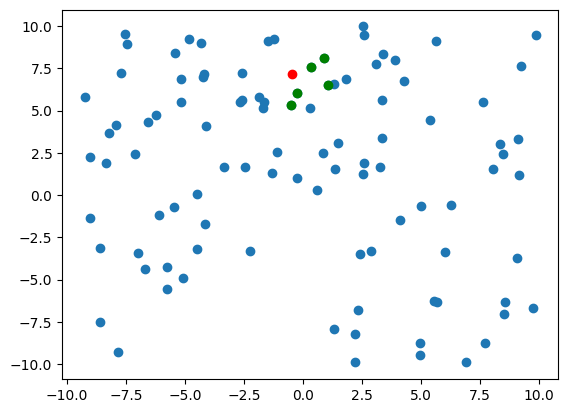

In [52]:
# Brute-force KNN
print("Brute-force KNN:")
neighbors_naive = brute_force_knn(data, query, k)
print(f"The {k} nearest neighbors are:")
for neighbor in neighbors_naive:
    print(neighbor)

# show the query point and its neighbors

data_plot = np.array(data)
plt.scatter(data_plot[:,0], data_plot[:,1])
plt.scatter(query[0], query[1], c='red')
plt.scatter([point[0] for point in neighbors_naive], [point[1] for point in neighbors_naive], c='green')
plt.show()



sklearn's brute force KNN:
[0.3621047332580307, 7.608870329172273]
[-0.2444149177299053, 6.042510621597163]
[0.88172156387337, 8.095797640625022]
[1.0701221790246365, 6.49310877046036]
[-0.49669875045095857, 5.318839186415769]


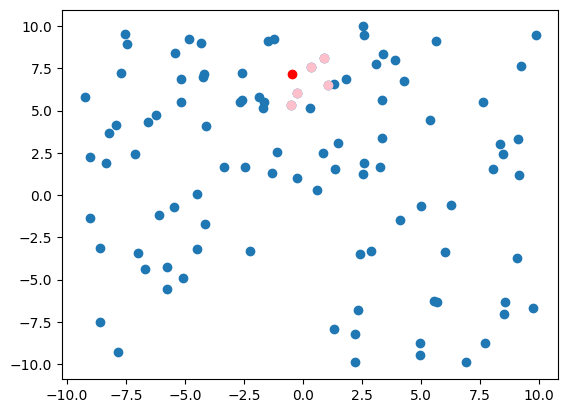

In [53]:
# sklearn's brute force KNN
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=k)
neigh.fit(data)
print("\nsklearn's brute force KNN:")
distances, indices = neigh.kneighbors([query])
for i in range(k):
    print(data[indices[0][i]])

# show query point and its neighbors
data_plot = np.array(data)
plt.scatter(data_plot[:,0], data_plot[:,1])
plt.scatter(query[0], query[1], c='red')
for i in range(k):
    plt.scatter(data[indices[0][i]][0], data[indices[0][i]][1], c='pink')



KD-tree KNN:
The 5 nearest neighbors are:
[-0.9186441289916871, 7.502388837184064]
[-0.04877275455027963, 5.268499769571136]
[0.8731996492670149, 8.856962167051655]
[-0.06458532361191871, 4.246446284532858]
[-0.921186973975578, 3.9809856000736215]


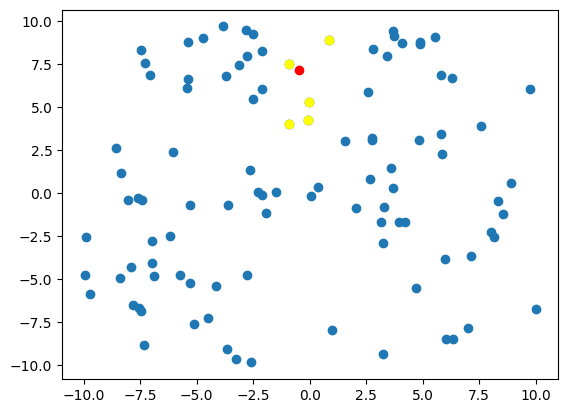

In [60]:
# KD-tree KNN
root = create_kdtree(data)
print("\nKD-tree KNN:")
neighbors_KD = kdtree_knn(root, query, k)
print(f"The {k} nearest neighbors are:")
for neighbor in neighbors_KD:
    print(neighbor)

# show the query point and its neighbors
data_plot = np.array(data)
plt.scatter(data_plot[:,0], data_plot[:,1])
plt.scatter(query[0], query[1], c='red')
plt.scatter([point[0] for point in neighbors_KD], [point[1] for point in neighbors_KD], c='yellow')
plt.show()

# # also show the partitioning in 2d space
# def plot_tree(node, min_bounds, max_bounds):
#     if node is None:
#         return

#     point = node.point
#     left = node.left
#     right = node.right
#     axis = node.axis

#     # Plot the point
#     plt.scatter(point[0], point[1])

#     # Get the minimum and maximum bounds
#     left_min_bounds = min_bounds[:]
#     left_max_bounds = max_bounds[:]
#     right_min_bounds = min_bounds[:]
#     right_max_bounds = max_bounds[:]
#     left_max_bounds[axis] = point[axis]
#     right_min_bounds[axis] = point[axis]

#     # Plot the splitting line
#     if axis == 0:
#         plt.plot([point[0], point[0]], [min_bounds[1], max_bounds[1]], c='gray')
#     else:
#         plt.plot([min_bounds[0], max_bounds[0]], [point[1], point[1]], c='gray')

#     # Recursively plot the children
#     plot_tree(left, left_min_bounds, left_max_bounds)
#     plot_tree(right, right_min_bounds, right_max_bounds)

# plt.figure()
# plt.axis('equal')
# plt.axis([-10, 10, -10, 10])
# plot_tree(root, [-10, -10], [10, 10])
# plt.show()




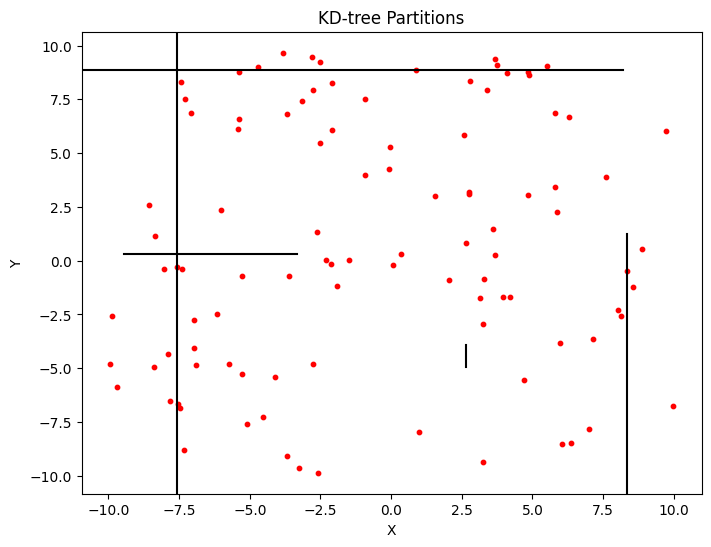

In [61]:
# show the partitioning in 2d space

def visualize_kdtree(root, ax):
    if root is not None:
        ax.scatter(root.point[0], root.point[1], c='r', s=10)
        if root.partition:
            if root.axis == 0:
                ax.axvline(x=root.partition[0], ymin=root.partition[1][0], ymax=root.partition[1][1], c='k')
            else:
                ax.axhline(y=root.partition[1], xmin=root.partition[0][0], xmax=root.partition[0][1], c='k')
        visualize_kdtree(root.left, ax)
        visualize_kdtree(root.right, ax)

# Visualize the KD-tree partitions
fig, ax = plt.subplots(figsize=(8, 6))
visualize_kdtree(root, ax)
ax.set_title('KD-tree Partitions')
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.show()

In [62]:
import time
import memory_profiler


# Vary D, fix K and N
K = 5
N = 100
D_values = range(2, 52)
brute_force_train_times = []
kdtree_train_times = []
brute_force_test_times = []
kdtree_test_times = []
brute_force_memories = []
kdtree_memories = []

for D in D_values:
    # Generate a random dataset
    data = [[random.uniform(-10, 10) for _ in range(D)] for _ in range(N)]
    query = [random.uniform(-10, 10) for _ in range(D)]

    # Brute-force KNN
    start_time = time.time()
    brute_force_train_times.append(start_time)
    neighbors = brute_force_knn(data, query, K)
    brute_force_train_times[-1] = time.time() - start_time
    start_time = time.time()
    brute_force_test_times.append(start_time)
    neighbors = brute_force_knn(data, query, K)
    brute_force_test_times[-1] = time.time() - start_time
    brute_force_memories.append(memory_profiler.memory_usage((brute_force_knn, (data, query, K))))

    # KD-tree KNN
    start_time = time.time()
    root = create_kdtree(data)
    kdtree_train_times.append(time.time() - start_time)
    start_time = time.time()
    neighbors = kdtree_knn(root, query, K)
    kdtree_test_times.append(time.time() - start_time)
    kdtree_memories.append(memory_profiler.memory_usage((create_kdtree, (data,))))



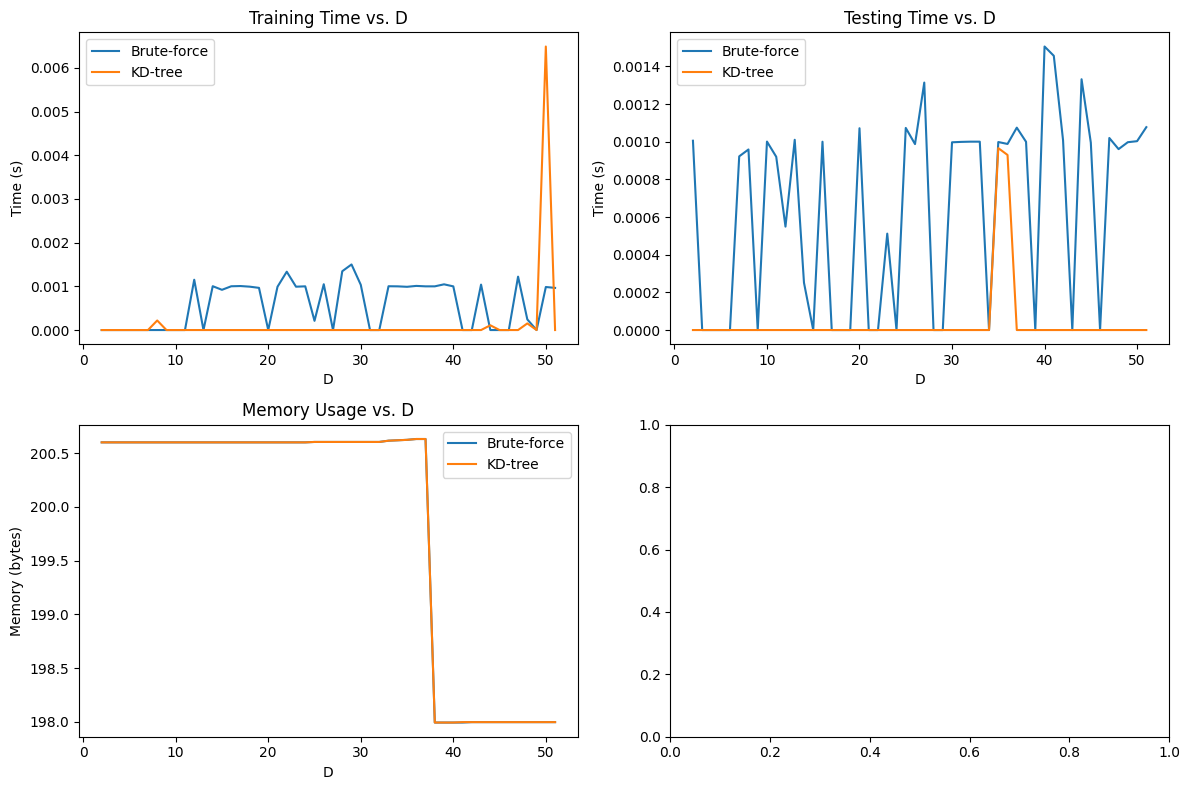

In [63]:
kdtree_memories = [max(mem) for mem in kdtree_memories]
brute_force_memories = [max(mem) for mem in brute_force_memories]

# Plot the results
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0, 0].plot(D_values, brute_force_train_times, label='Brute-force')
axs[0, 0].plot(D_values, kdtree_train_times, label='KD-tree')
axs[0, 0].set_title('Training Time vs. D')
axs[0, 0].set_xlabel('D')
axs[0, 0].set_ylabel('Time (s)')
axs[0, 0].legend()

axs[0, 1].plot(D_values, brute_force_test_times, label='Brute-force')
axs[0, 1].plot(D_values, kdtree_test_times, label='KD-tree')
axs[0, 1].set_title('Testing Time vs. D')
axs[0, 1].set_xlabel('D')
axs[0, 1].set_ylabel('Time (s)')
axs[0, 1].legend()

axs[1, 0].plot(D_values, brute_force_memories, label='Brute-force')
axs[1, 0].plot(D_values, kdtree_memories, label='KD-tree')
axs[1, 0].set_title('Memory Usage vs. D')
axs[1, 0].set_xlabel('D')
axs[1, 0].set_ylabel('Memory (bytes)')
axs[1, 0].legend()

plt.tight_layout()
plt.show()

In [64]:
# Vary N, fix K and D

K = 5
D = 5
N_values = range(10, 1000, 30)
brute_force_train_times = []
kdtree_train_times = []
brute_force_test_times = []
kdtree_test_times = []
brute_force_memories = []
kdtree_memories = []

for N in N_values:
    # Generate a random dataset
    data = [[random.uniform(-10, 10) for _ in range(D)] for _ in range(N)]
    query = [random.uniform(-10, 10) for _ in range(D)]

    # Brute-force KNN
    start_time = time.time()
    brute_force_train_times.append(start_time)
    neighbors = brute_force_knn(data, query, K)
    brute_force_train_times[-1] = time.time() - start_time
    start_time = time.time()
    brute_force_test_times.append(start_time)
    neighbors = brute_force_knn(data, query, K)
    brute_force_test_times[-1] = time.time() - start_time
    brute_force_memories.append(memory_profiler.memory_usage((brute_force_knn, (data, query, K))))

    # KD-tree KNN
    start_time = time.time()
    root = create_kdtree(data)
    kdtree_train_times.append(time.time() - start_time)
    start_time = time.time()
    neighbors = kdtree_knn(root, query, K)
    kdtree_test_times.append(time.time() - start_time)
    kdtree_memories.append(memory_profiler.memory_usage((create_kdtree, (data,))))

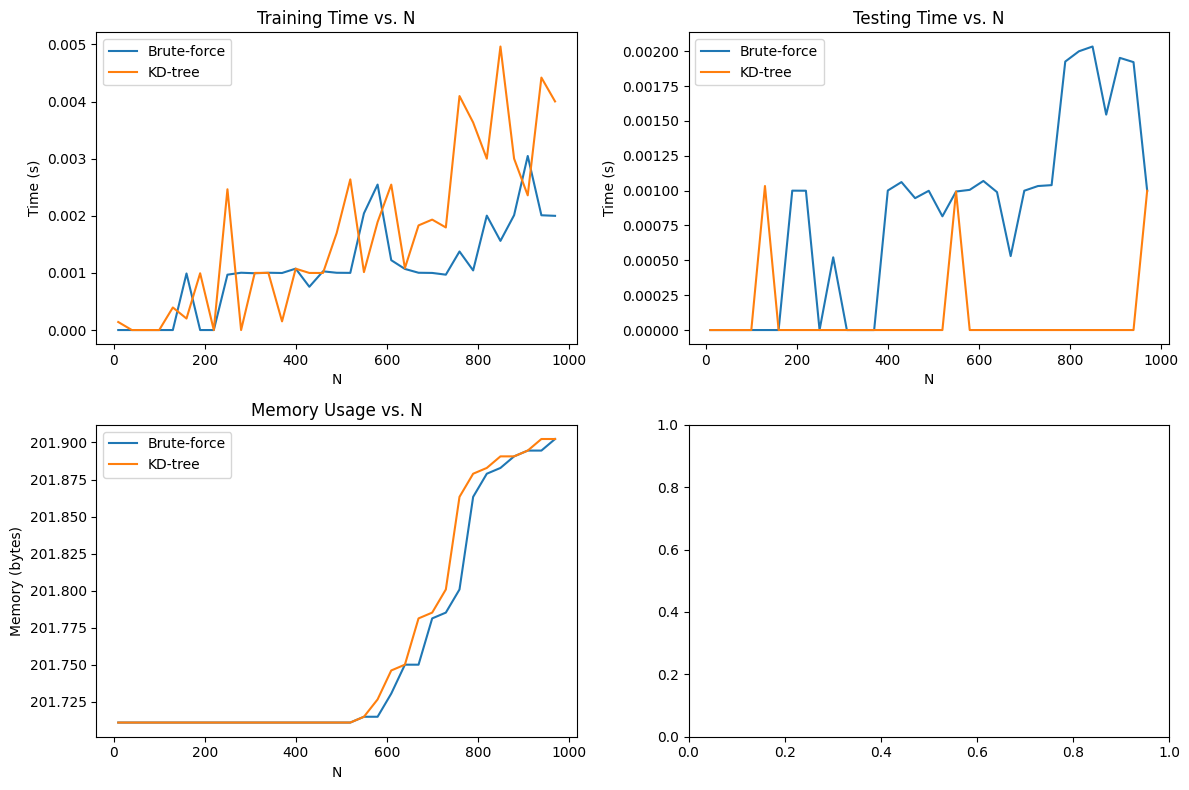

In [65]:
kdtree_memories = [max(mem) for mem in kdtree_memories]
brute_force_memories = [max(mem) for mem in brute_force_memories]

# Plot the results
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0, 0].plot(N_values, brute_force_train_times, label='Brute-force')
axs[0, 0].plot(N_values, kdtree_train_times, label='KD-tree')
axs[0, 0].set_title('Training Time vs. N')
axs[0, 0].set_xlabel('N')
axs[0, 0].set_ylabel('Time (s)')
axs[0, 0].legend()

axs[0, 1].plot(N_values, brute_force_test_times, label='Brute-force')
axs[0, 1].plot(N_values, kdtree_test_times, label='KD-tree')
axs[0, 1].set_title('Testing Time vs. N')
axs[0, 1].set_xlabel('N')
axs[0, 1].set_ylabel('Time (s)')
axs[0, 1].legend()

axs[1, 0].plot(N_values, brute_force_memories, label='Brute-force')
axs[1, 0].plot(N_values, kdtree_memories, label='KD-tree')
axs[1, 0].set_title('Memory Usage vs. N')
axs[1, 0].set_xlabel('N')
axs[1, 0].set_ylabel('Memory (bytes)')
axs[1, 0].legend()

plt.tight_layout()
plt.show()
